In [3]:
import sys
#import packages for python 
import cv2 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import csv

import diplib as dip
from plantcv import plantcv as pcv #"pip install plantcv"   "https://plantcv.readthedocs.io/en/stable/installation/"

%matplotlib inline
print(cv2.__version__)
print(dip.__version__)
print(pcv.__version__)
np.set_printoptions(threshold=sys.maxsize)

4.7.0
3.4.0
3.14.3


### Use guide

---

Use the ```filename``` object to give a file path to images to be analyzed. Input images are assumed to be already thresholded (a binary image) as well as 8bit. Feel free to modify image opening to suit different use cases

---

Set ```junction_cutoff``` to an appropriate diameter to remove junctions from measurements. This is done since junctions will generally be larger than stripewidth due to diagonal measurements. 

---

Set ```pixel_to_micron``` to adjust for your system (doesn't need to be to microns)

---

The outputs include a csv file of measurements, and the associated histogram

---


Average Width 2.1673252279635253
Standard Deviation 0.16405484707648837


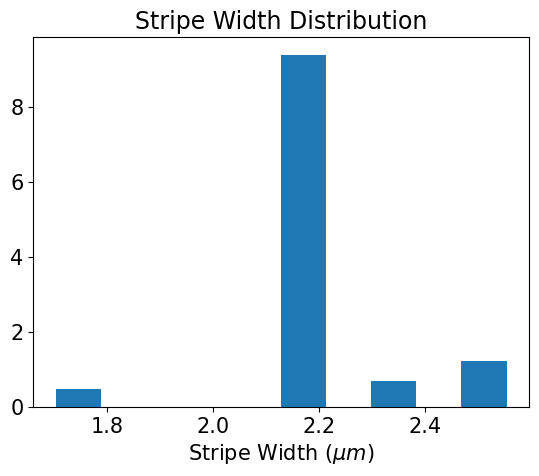

In [4]:
###
filename="C:/Users/bjorn/Downloads/Image12826-thresh"
###

original = cv2.imread(filename+".tif" ,cv2.IMREAD_GRAYSCALE)
img=np.pad(original,((20,20),(20,20)),mode='minimum')
cv2.imshow('img',img)
cv2.waitKey()

###
pixel_to_micron=4.7 #4.7pi to 1micron
###

###
junction_cutoff=13 ###Change this for each image until it works well!!
###

contours,heir = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
imemp = np.zeros(img.shape) 
imcon = cv2.drawContours(imemp,contours,-1,(255))
imcon= np.uint8(imcon)
center = dip.Image(img) ; center = dip.Opening(center,junction_cutoff) ; center = np.array(center) ; center = np.uint8(center) ; center = cv2.bitwise_not(center) ; img=cv2.bitwise_and(center,img)
imemp = np.zeros(img.shape)
cv2.imshow('imga',img)
cv2.waitKey()
cv2.destroyAllWindows()
Wid=[]
ls=[]

for i in range(junction_cutoff,7,-1):
    imga = dip.Image(img)
    imga = dip.Opening(imga,i) ; imga = np.array(imga) ; imga = np.uint8(imga)
    outline = cv2.bitwise_or(imcon.copy(),imga)
    im=cv2.resize(imga,(600,600))
    cv2.imshow('imga',outline)
    cv2.waitKey(10)
    
    skelt = pcv.morphology.skeletonize(imga) ; skelt  = pcv.morphology.prune(skelt,80) ; skelt = np.uint8(skelt[0])
    skelt=np.ndarray.flatten(skelt)
    length=np.bincount(skelt)
    if len(length) >1:
        length=length[255]
        wid=[i]*length 
        Wid=Wid+wid
        ls.append(length)
        
    img=cv2.bitwise_xor(img,imga)
pixel_to_micron=4.7 #4.7pi to 1micron
WID=np.array(Wid)/pixel_to_micron
stdev=np.std(WID)
Width=np.sum(WID)/sum(ls)
print('Average Width',Width)
print('Standard Deviation',stdev)
Avgwid=[Width]+([0]*(sum(ls)-1)) ; STDev=[stdev]+([0]*(sum(ls)-1))
WIDTH=pd.DataFrame({'Average Width':Avgwid,'Standard Deviation':STDev,'Widths':WID})
WIDTH.to_csv(filename+"Width.csv",sep=',')  #Save CSV
plt.hist(WID,density=True)
plt.yticks(fontsize=15)
plt.title("Stripe Width Distribution",fontsize=17)
plt.xlabel(f"Stripe Width ($\mu m$)",fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(filename+"Hist.png",dpi=250, bbox_inches = "tight")
cv2.destroyAllWindows()